## Introduction ##

Diabetes is a chronic medical condition where patients are either unable to make enough insulin or their body doesn't respond to the insulin it produces. In either case, the blood sugar levels in patients become high as the body can’t store the sugar properly in the body. These high blood sugar levels can cause serious health problems over time.

Our question we tried to answer is whether or not we can predict diabetes in a patient, given a set of diagnostic measurements for each patient. 

The dataset we used can be found here: https://www.kaggle.com/datasets/mathchi/diabetes-data-set

The dataset is a subset of data taken from the National Institute of Diabetes and Digestive and Kidney Diseases. It focuses specifically on female patients at least 21 years old of Pima Indian heritage.

## Methods ##

### Loading Data and Packages ###

In [1]:
### Run this cell before continuing.
import altair as alt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

# Simplify working with large datasets in Altair
alt.data_transformers.disable_max_rows()

# Output dataframes instead of arrays
set_config(transform_output="pandas")

In [2]:
URL = "https://raw.githubusercontent.com/adipoluri/DSCI-100-Project/main/diabetes.csv"
diabetes_raw_df = pd.read_csv(URL)
diabetes_raw_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Table 1: The Raw Diabetes Dataset From Kaggle

### Data Wrangling and Exploratory Data Analysis

We noticed that there were 0 values in the following columns: "Glucose", "BloodPressure", "SkinThickness", "Insulin" and "BMI".

On pg 263 of the paper that previously used this dataset(see the "Past Usage" section in the Kaggle link), we can see from Table 1 that there were "BLANK" values for each of these features. We believe the 0 values that we're seeing in the columns represent those "BLANK" values, so we have decided to remove examples that have 0 in any of those columns from the dataset we'll be using for the remainder of this project (see below).

In [3]:
diabetes_df = diabetes_raw_df[
(diabetes_raw_df["Glucose"] > 0) & (diabetes_raw_df["BloodPressure"] > 0) & (diabetes_raw_df["SkinThickness"] > 0) &
(diabetes_raw_df["Insulin"] > 0) & (diabetes_raw_df["BMI"] > 0)]

diabetes_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
...,...,...,...,...,...,...,...,...,...
753,0,181,88,44,510,43.3,0.222,26,1
755,1,128,88,39,110,36.5,1.057,37,1
760,2,88,58,26,16,28.4,0.766,22,0
763,10,101,76,48,180,32.9,0.171,63,0


Table 2: Modified Diabetes Dataset (Rows with BLANK Values Removed)

In [4]:
diabetes_df.describe(include = "all")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Table 3: Exploratory Summary Table for the Modified Diabetes Dataset

We can see that after removing the rows with BLANK values, we no longer have 0 as the min for our "Glucose", "BloodPressure", "SkinThickness", "Insulin" and "BMI" columns

#### Splitting the data into training set (75%) and test set (25%)

In [5]:
train_df, test_df = train_test_split(diabetes_df, test_size=0.25, random_state=123)

In [6]:
train_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
260,3,191,68,15,130,30.9,0.299,34,0
548,1,164,82,43,67,32.8,0.341,50,0
27,1,97,66,15,140,23.2,0.487,22,0
320,4,129,60,12,231,27.5,0.527,31,0
599,1,109,38,18,120,23.1,0.407,26,0
...,...,...,...,...,...,...,...,...,...
450,1,82,64,13,95,21.2,0.415,23,0
204,6,103,72,32,190,37.7,0.324,55,0
631,0,102,78,40,90,34.5,0.238,24,0
744,13,153,88,37,140,40.6,1.174,39,0


Table 4: Training Dataset

In [7]:
train_summary = train_df.describe()
train_summary

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,3.302721,123.908163,70.721088,29.187075,156.996599,33.324830,0.540650,30.955782,0.340136
std,3.245400,31.507002,12.458139,10.518099,123.516604,7.380823,0.358113,10.348604,0.474562
min,0.000000,56.000000,30.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,100.000000,62.000000,22.000000,76.000000,28.400000,0.289000,23.000000,0.000000
50%,2.000000,120.000000,70.000000,29.000000,126.000000,33.100000,0.465000,27.000000,0.000000
75%,5.000000,144.750000,78.000000,37.000000,190.750000,37.575000,0.690750,36.750000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Table 4: Exploratory Data Summary for Training Dataset

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 260 to 711
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               294 non-null    int64  
 1   Glucose                   294 non-null    int64  
 2   BloodPressure             294 non-null    int64  
 3   SkinThickness             294 non-null    int64  
 4   Insulin                   294 non-null    int64  
 5   BMI                       294 non-null    float64
 6   DiabetesPedigreeFunction  294 non-null    float64
 7   Age                       294 non-null    int64  
 8   Outcome                   294 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 23.0 KB


Table 5: Exploratory Information for Training Dataset

In [9]:
numeric_cols_initial = list(train_summary.select_dtypes([np.number]).columns) 
numeric_cols_initial

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

#### Listing the columns of the dataset and selecting the first 8 (the predictors) and not the outcome column 

In [10]:
numeric_cols = numeric_cols_initial[:8]
numeric_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### EDA Visualizations
For each column, we created a histogram with a predictor variable of that column on the x-axis and diabetes outcome frequency on the y-axis.

By viewing these graphs, we were able to select a set of predictors that we believed would be the most useful in our prediction of whether a patient has diabetes or not.

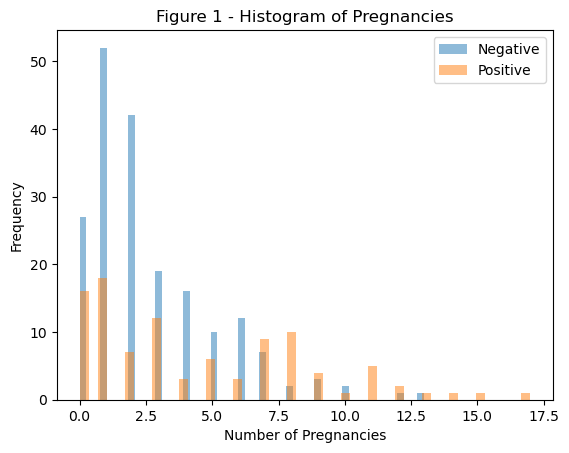

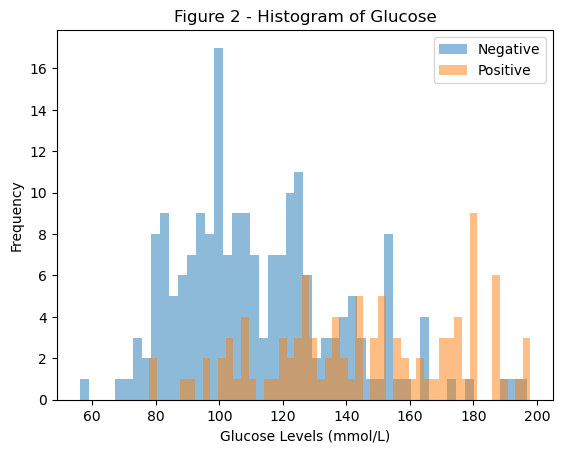

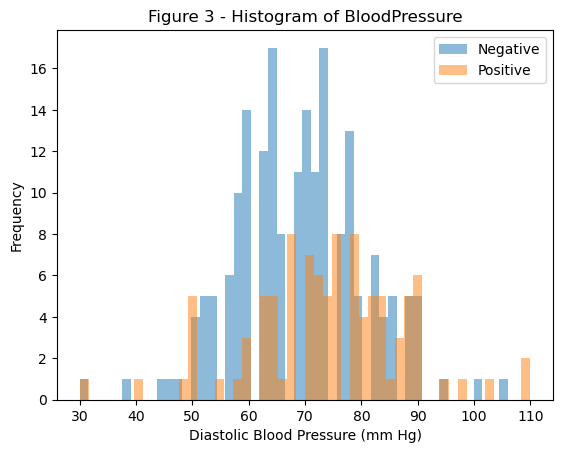

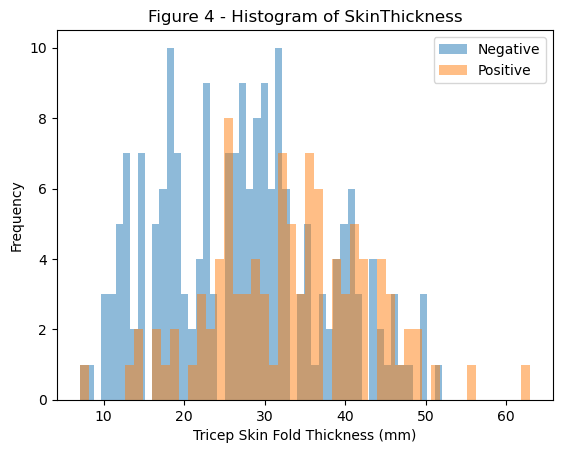

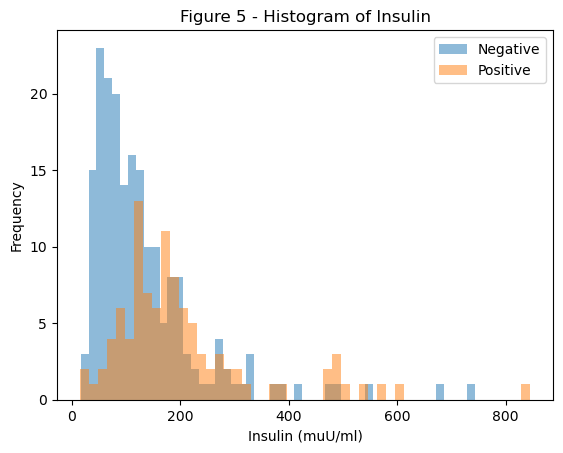

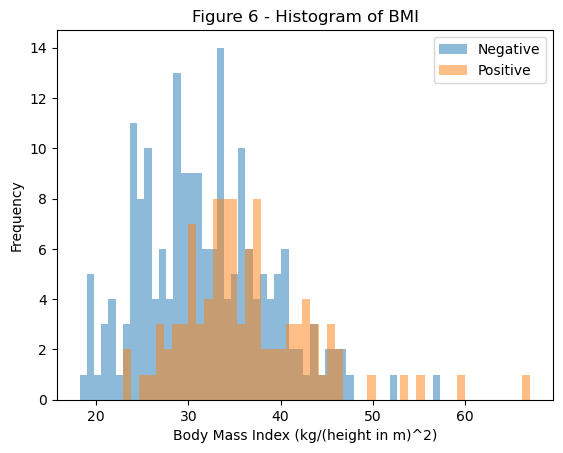

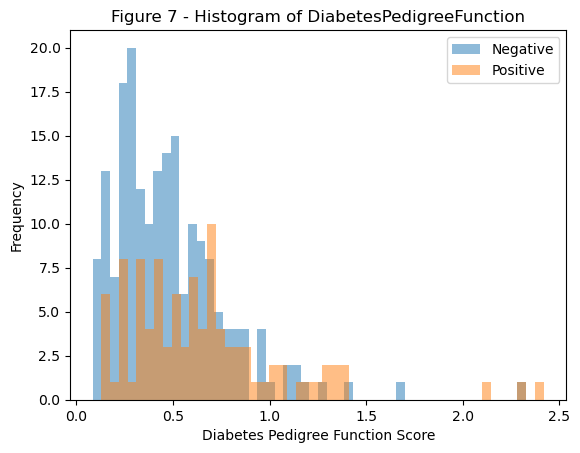

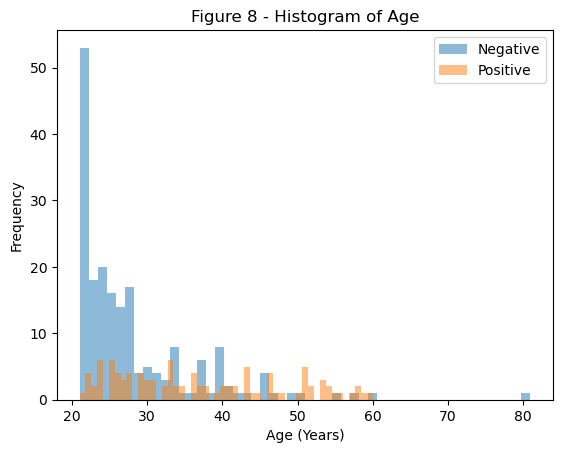

In [28]:
## Pregnancies ##
units = {
    "Pregnancies":"Number of Pregnancies",
    "Glucose":"Glucose Levels (mmol/L)",
    "BloodPressure":"Diastolic Blood Pressure (mm Hg)",
    "SkinThickness":"Tricep Skin Fold Thickness (mm)",
    "Insulin":"Insulin (muU/ml)",
    "BMI":"Body Mass Index (kg/(height in m)^2)",
    "DiabetesPedigreeFunction":"Diabetes Pedigree Function Score",
    "Age":"Age (Years)",
}

for i, n in enumerate(numeric_cols):
    ax = train_df.groupby("Outcome")[n].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(units[n])
    plt.title("Figure {} - Histogram of {}".format(i+1, n))
    plt.legend(["Negative","Positive"])
    plt.show()

## Analysis ##

From the EDA and histograms above, we can see that some variables look like they'll be more useful for our predictions than others. We looked for the variables where we can see some separation in the histograms between the "negative" class (ie has diabetes) and the "positive" class (ie doesn't have diabetes). So, we decided to use "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", and "Diabetes Pedigree Score" as the "useful" variables in our data analysis.

#### Splitting the train and test data into X and y while also dropping unused columns

In [12]:
X_train, y_train = (
    train_df.drop(columns=["Pregnancies", "Age", "BMI", "Outcome"]),
    train_df["Outcome"],
)
X_test, y_test = (
    test_df.drop(columns=["Pregnancies", "Age", "BMI", "Outcome"]),
    test_df["Outcome"],
)
X_train

,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction
260,191,68,15,130,0.299
548,164,82,43,67,0.341
27,97,66,15,140,0.487
320,129,60,12,231,0.527
599,109,38,18,120,0.407
...,...,...,...,...,...
450,82,64,13,95,0.415
204,103,72,32,190,0.324
631,102,78,40,90,0.238
744,153,88,37,140,1.174


Table 6: The X for our Training Dataset

#### Creating a dictionary of classification models for ease of use

We wanted to try out different classification models to see which ones would give us the best results. So we chose 3 common classification models.

In [13]:
models = {
    "decision tree": DecisionTreeClassifier(random_state=42),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=42),
}

In [14]:
diabetes_pred_results_dict = {}
diabetes_pred_results_dict

{}

In [15]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

#### Displaying the train and cross validation scores to analyze the effectiveness of different classification models

In [34]:
pipe_dt = make_pipeline(StandardScaler(), models["decision tree"])
diabetes_pred_results_dict[models["decision tree"]] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, cv=5, return_train_score=True
)
diabetes_pred_results_df = pd.DataFrame(diabetes_pred_results_dict).T

pipe_knn = make_pipeline(StandardScaler(), models["kNN"])
diabetes_pred_results_dict[models["kNN"]] = mean_std_cross_val_scores(
    pipe_knn, X_train, y_train, cv=5, return_train_score=True
)
diabetes_pred_results_df = pd.DataFrame(diabetes_pred_results_dict).T


pipe_rbf = make_pipeline(StandardScaler(), models["RBF SVM"])
diabetes_pred_results_dict[models["RBF SVM"]] = mean_std_cross_val_scores(
    pipe_rbf, X_train, y_train, cv=5, return_train_score=True
)
diabetes_pred_results_df = pd.DataFrame(diabetes_pred_results_dict).T
diabetes_pred_results_df

,fit_time,score_time,test_score,train_score
DecisionTreeClassifier(random_state=42),0.005 (+/- 0.000),0.002 (+/- 0.000),0.650 (+/- 0.020),1.000 (+/- 0.000)
KNeighborsClassifier(),0.004 (+/- 0.000),0.005 (+/- 0.000),0.728 (+/- 0.058),0.810 (+/- 0.016)
SVC(random_state=42),0.005 (+/- 0.000),0.002 (+/- 0.000),0.724 (+/- 0.053),0.826 (+/- 0.005)


Table 7: Training and Cross Validation Scores for Different Classification Models

From Table 7, we can see that KNeighborsClassifier (ie K-NN) gave us the best cross validation scores. So, we decided that going forward, we would be using K-NN as the classifier for predicting diabetes in the patients.

#### Showing train and cross validation scores for different n_neighbours values

In [19]:
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"n_neighbors": np.arange(1, 50, 5)}

for k in param_grid["n_neighbors"]:
    pipe_knn2 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    scores = cross_validate(pipe_knn2, X_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)

In [20]:
results_df = results_df.set_index("n_neighbors")
results_df

,mean_train_score,mean_cv_score,std_cv_score,std_train_score
n_neighbors,,,,
1,1.000000,0.659848,0.018713,0.000000
6,0.789098,0.693863,0.038707,0.010929
11,0.772943,0.731034,0.038495,0.011268
16,0.764432,0.741204,0.052627,0.017010
21,0.767825,0.744652,0.051803,0.020723
26,0.757638,0.734483,0.045171,0.013162
31,0.763588,0.744711,0.047903,0.016724
36,0.769546,0.751490,0.041091,0.015718
41,0.770389,0.744711,0.045441,0.013200


Table 8: Training and Cross Validation Scores With Different N_Neighbours Values

#### Creating plot of train accuracy vs cv accuracy to choose an effective k-value

Text(0.5, 1.0, 'Figure 9 - Average Training and Cross Validation Scores')

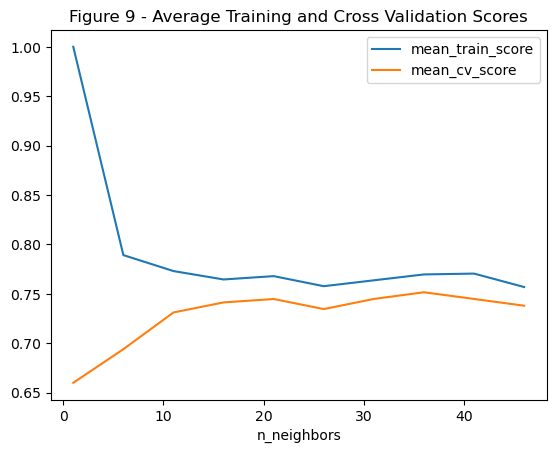

In [38]:
results_df[["mean_train_score", "mean_cv_score"]].plot()
plt.title("Figure 9 - Average Training and Cross Validation Scores")

We ended up choosing n_neighbors=16 because it is an ideal balance between cv score and efficiency. While n_neighbors=36 technically produces the highest mean cross validation score, the difference is not significant enough to justify the increased resource usage.

#### Creating pipeline based on best model (K-nn with n=16), fitting model to train data, and then displaying test accuracy and predictions

In [43]:
pipe_best = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=21))
diabetes_fit = pipe_best.fit(X_train, y_train)
print("Test accuracy: %0.3f" % (pipe_best.score(X_test, y_test)))

Test accuracy: 0.796


In [44]:
diabetes_test_predictions = test_df.assign(
    Predicted=diabetes_fit.predict(X_test)
)
diabetes_test_predictions

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Predicted
429,1,95,82,25,180,35.0,0.233,43,1,0
480,3,158,70,30,328,35.5,0.344,35,1,1
285,7,136,74,26,135,26.0,0.647,51,0,0
301,2,144,58,33,135,31.6,0.422,25,1,0
763,10,101,76,48,180,32.9,0.171,63,0,0
...,...,...,...,...,...,...,...,...,...,...
248,9,124,70,33,402,35.4,0.282,34,0,0
360,5,189,64,33,325,31.2,0.583,29,1,1
91,4,123,80,15,176,32.0,0.443,34,0,0
390,1,100,66,29,196,32.0,0.444,42,0,0


Table 9: Test Dataset with Predictions Added

#### Visualization of Test Predictions

In [46]:
cols_used = [
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'DiabetesPedigreeFunction']

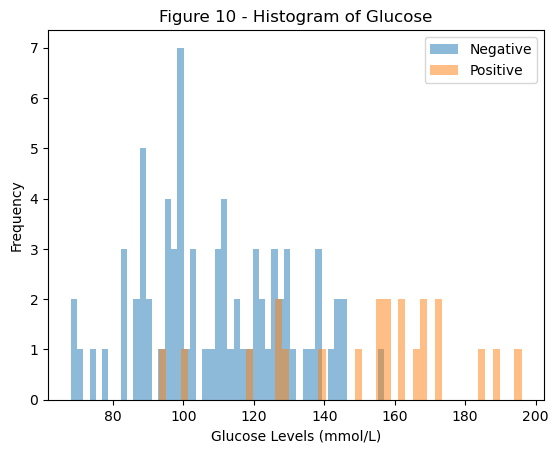

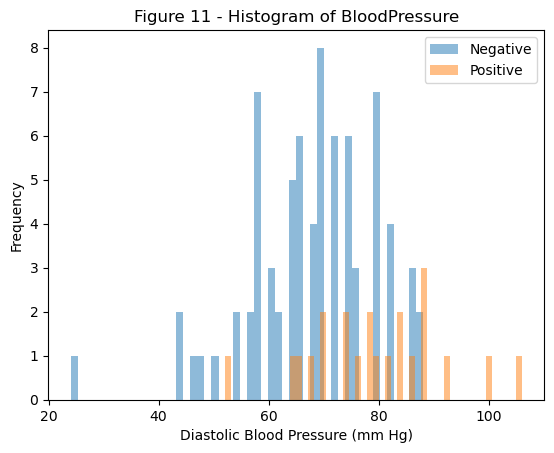

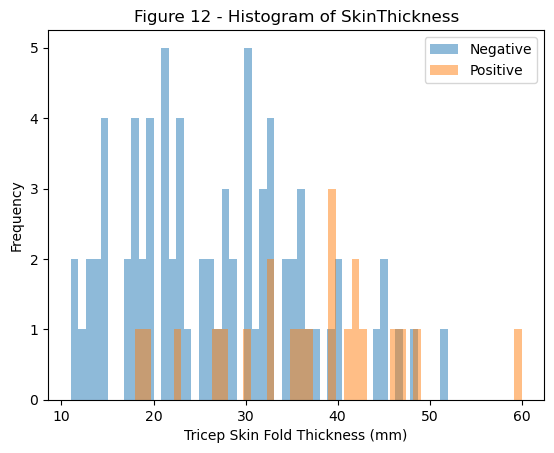

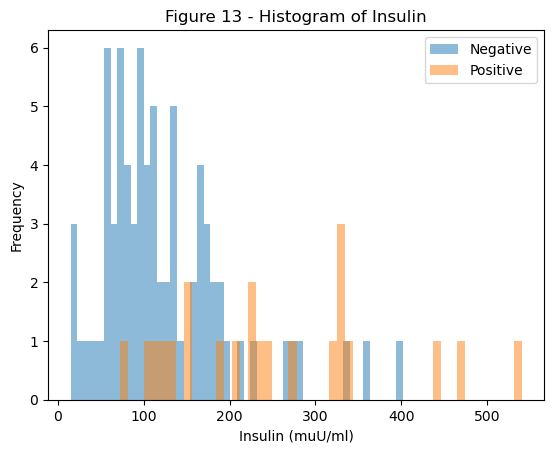

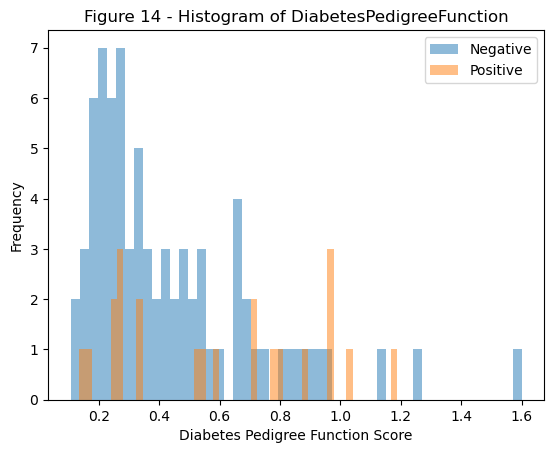

In [48]:
for i, n in enumerate(cols_used):
    ax = diabetes_test_predictions.groupby("Predicted")[n].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(units[n])
    plt.title("Figure {} - Histogram of {}".format(i+10, n))
    plt.legend(["Negative","Positive"])
    plt.show()

## Discussion

We found that using a K-nn classifier (with n_neighbours = 16), we were able to predict diabetes in patients accurately 79.6% of the time. This was done using Glucose, Blood Pressure, Skin Thickness, Insulin and Diabetes Pedigree Function as the predictor variables.

This was somewhat like we what we had expected. We were expecting to find some set of predictor variables that would be useful for predicting diabetes in patients. We were surprised at the accuracy we managed to get as well as at the number of predictor variables we ended up using in our model.

Knowing which diagnostic measurements lead to a positive diabetes diagnosis can be important for doctors to monitor the risk of their patients developing diabetes.  Knowing this in advance can help doctors and patients work together to manage their diabetes or even help prevent them from developing diabetes if they are able to intervene quickly. 

Since this dataset only focused on female patients of a particular age and of a particular ethnicity, we could extend the patient demographics in the future to see if we can generalize our model for a more diverse set of patients. In the future, we could also work on narrowing down the number of predictor variables to see which ones truly were the most important in predicting diabetes. This would make diagnosis of diabetes simpler in patients as less tests would need to be done.

## References ##

* Balkau, B., Lange, C., Fezeu, L., Tichet, J., de Lauzon-Guillain, B., Czernichow, S., Fumeron, F., Froguel, P., Vaxillaire, M., Cauchi, S., Ducimetière, P., & Eschwège, E. (2008). Predicting diabetes: clinical, biological, and genetic approaches: data from the Epidemiological Study on the Insulin Resistance Syndrome (DESIR). Diabetes care, 31(10), 2056–2061. https://doi.org/10.2337/dc08-0368

* Smith, J. W., Everhart, J. E., Dickson, W. C., Knowler, W. C., & Johannes, R. S. (1988). Using the ADAP Learning Algorithm to Forecast the Onset of Diabetes Mellitus. Proceedings of the Annual Symposium on Computer Application in Medical Care, 261–265.

Data Source: National Institute of Diabetes and Digestive and Kidney Diseases